This code is mainly based on the YouTube tutorial: 
  * [Email Spam Detection Using Python & Machine Learning](https://www.youtube.com/watch?v=cNLPt02RwF0&list=WL&index=4&t=12s)
	

It was modified based on:
  * ["Spam or Ham" tutorial](https://github.com/tejank10/Spam-or-Ham/blob/master/spam_ham.ipynb)

  * [Sololearn (Machine Learning path)](https://www.sololearn.com/learning/1094)

  * [Machine Learning for Absolute Beginners book](https://www.amazon.co.uk/Machine-Learning-Absolute-Beginners-Introduction-ebook/dp/B08RWBSKQB)


Import the required libraries:
  1. ***pandas*** for importing dataset(*)
  2. ***matplotlib*** for visualisation
  3. ***string*** & ***nltk*** for object manipulation
  4. ***sklearn*** for machine learning
  5. ***wordcloud*** for wordcloud visualization

In [11]:
import pandas as pd
import string
import matplotlib.pyplot as plt
import nltk

from nltk.corpus import stopwords
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud

In [2]:
# Load data
from google.colab import files
uploaded = files.upload()

Saving emails.csv to emails.csv


In [3]:
# read the CSV file
df = pd.read_csv('emails.csv')

# print the first 5 rows of data
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


# **Data Cleaning Process**

  * Duplicates
  * Missing values

In [4]:
# print the number of rows and columns
df.shape

(5728, 2)

In [6]:
# check for duplicates
print(df.duplicated().sum())
# remove duplicates
df.drop_duplicates(inplace=True)

0


In [7]:
# check for missing values
df.isna().sum()

text    0
spam    0
dtype: int64

# **Object Manipulation Process**

  1. Remove punctuation from text
  2. Remove stopwords from text
  3. Split text in individual words

In [12]:
# download the stopwords package
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Define a function that:
  1. Removes punctuation symbols and stopwords from a text
  2. Splits the text into individual words
  3. Stores the individual words in a list

In [13]:
def process_text(text):
	"""
		Returns a list of strings (individual words) of a text (paragraph) excluding
		punctuation, stopwords.

			Parameters
			----------
				text: An object (string) variable.

			Returns
			-------
				clean_words: A list of objects (string).
		"""
	# create an empty list to later store the rows (emails) without punctuation
	no_punctuation = []
	# create an empty list to later store the words of each row (email)
	clean_words = []
	# for every row (email) in the text column
	for char in text:
		# remove every punctuation symbol
		if char not in string.punctuation:
			# append the free-of-punctuation row in the list "no_punctuation"
			no_punctuation.append(char)
	# insert an empty space between words
	no_punctuation = ''.join(no_punctuation)

	# for every row (email without punctuation symbols) in
	# the "no_punctuation" list split the text into words
	for word in no_punctuation.split():
		# convert every word in lowercase
		word = word.lower()
		# if this word is not a stopword
		if word not in stopwords.words('english'):
			# append the free-of-stopwords words in the list "clean_words"
			clean_words.append(word)
	# give back the list "clean_words"
	return clean_words

Apply the function "process_text" to the column "text" so we end up with a column of individual words and print the first 5 rows.

In [14]:
df['text'].head().apply(process_text)

0    [subject, naturally, irresistible, corporate, ...
1    [subject, stock, trading, gunslinger, fanny, m...
2    [subject, unbelievable, new, homes, made, easy...
3    [subject, 4, color, printing, special, request...
4    [subject, money, get, software, cds, software,...
Name: text, dtype: object

***CountVectorizer*** transforms a given text into a vector on the basis of 
the frequency (count) of each word that occurs in the entire text. 

More info on how it works [here](https://www.geeksforgeeks.org/using-countvectorizer-to-extracting-features-from-text/).

In [38]:
# convert a collection of text to a matrix of tokens (*bow = bog of words)
messages_bow = CountVectorizer(analyzer=process_text).fit_transform(df['text'])

Create a wordcloud visualisation for the spam words.

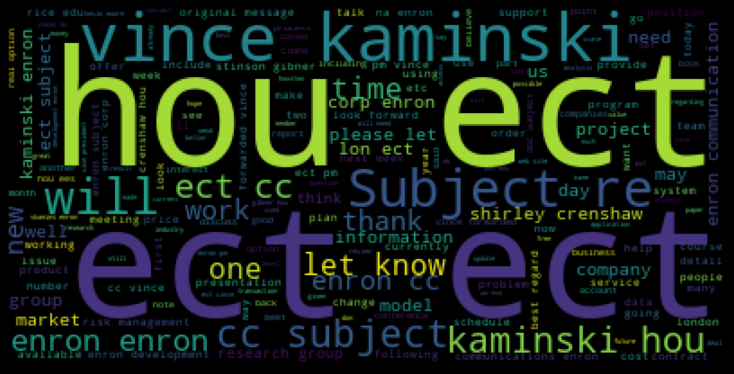

In [32]:
spam_wordcloud = WordCloud(width=512, height=512).generate(' '.join(df['text']))
plt.figure(figsize=(10, 8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# **Model Training Process**

In [39]:
# assign X and y variables
X = messages_bow
y = df['spam']

# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                    random_state=1)

In [40]:
# get the shape of X (rows, columns)
X.shape

(5695, 37228)

Justification of Model Selection

In [41]:
# select the model
model = MultinomialNB()

# train the model
model.fit(X_train, y_train)

MultinomialNB()

# **Model Evaluation**

In [42]:
# check the prediction on the training set
y_pred_train = model.predict(X_train)
print('Accuracy Score on Training set: ',
      round(accuracy_score(y_train, y_pred_train), 4))
# use the model to predict on the testing set
y_pred_test = model.predict(X_test)
print('Accuracy Score on Testing set: ',
      round(accuracy_score(y_test, y_pred_test), 4))

Accuracy Score on Training set:  0.9971
Accuracy Score on Testing set:  0.9912


In [44]:
# print the classification report on the testing set
print("\n\t\t\tCLASSIFICATION REPORT\n\n",
      classification_report(y_test, y_pred_test))

# print the confusion matrix of the testing set
print("\nCONFUSION MATRIX\n", confusion_matrix(y_test, y_pred_test))


			CLASSIFICATION REPORT

               precision    recall  f1-score   support

           0       1.00      0.99      0.99       866
           1       0.97      0.99      0.98       273

    accuracy                           0.99      1139
   macro avg       0.98      0.99      0.99      1139
weighted avg       0.99      0.99      0.99      1139


CONFUSION MATRIX
 [[858   8]
 [  2 271]]
